#### DeBERTa model

In [1]:
!pip install datasets
!pip install accelerate -U

In [2]:
# reference: https://www.kaggle.com/code/idv2005/deberta-baseline-train

import torch
import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from transformers import EarlyStoppingCallback
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/My Drive/6600-project/train.csv')
df['labels'] = df['score'] - 1

test = pd.read_csv('/content/drive/My Drive/6600-project/test.csv')


#### Define hyperparameters, tokenizer, and the model

In [5]:
# define hyperparameters

model_name = 'microsoft/deberta-v3-xsmall'
batch_size = 32
max_len = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels = 6)
n_epochs = 10
lr = 1e-05

# tokenization on text data
def tokenize(sample):
    return tokenizer(sample['full_text'], max_length=max_len, truncation=True)

# train-val split
train_df = df.sample(frac = 0.8, random_state = 123)
val_df = df.drop(train_df.index).reset_index(drop = True)
train_df = train_df.reset_index(drop = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


In [6]:
# pandas to dataset
ds_train = Dataset.from_pandas(train_df)
ds_val = Dataset.from_pandas(val_df)

ds_train = ds_train.map(tokenize).remove_columns(['essay_id','full_text','score'])
ds_val = ds_val.map(tokenize).remove_columns(['essay_id','full_text','score'])

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

In [7]:
# define training arguments and trainer

train_args = TrainingArguments(
    output_dir = "./", # model output directory
    learning_rate=lr, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=n_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch", # evaluate the results per epoch
    save_strategy="epoch", # save the model per epoch
    load_best_model_at_end=True, # load the best model after training
    no_cuda = False, # False if using cuda
    metric_for_best_model="qwk",
    greater_is_better=True # set the largest qwk as the opt model
)

def compute_metrics(p):
    preds, labels = p
    score = cohen_kappa_score(labels, preds.argmax(-1), weights='quadratic')
    return { 'qwk':score }

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)] # add early stopping
)

#### Train the model

In [8]:
trainer.train()

Epoch,Training Loss,Validation Loss,Qwk
1,No log,0.991912,0.713911
2,1.212500,0.918230,0.722615
3,0.957200,1.005216,0.714391
4,0.872100,0.908457,0.765207
5,0.831800,0.879039,0.780203
6,0.800500,0.880198,0.784857
7,0.780900,0.886024,0.781221
8,0.780900,0.866643,0.789548
9,0.760300,0.864128,0.795000
10,0.742400,0.865375,0.794000


TrainOutput(global_step=4330, training_loss=0.8598169551435298, metrics={'train_runtime': 5526.0329, 'train_samples_per_second': 25.056, 'train_steps_per_second': 0.784, 'total_flos': 9121682859677568.0, 'train_loss': 0.8598169551435298, 'epoch': 10.0})

#### Visualize the final results (confusion matrix)

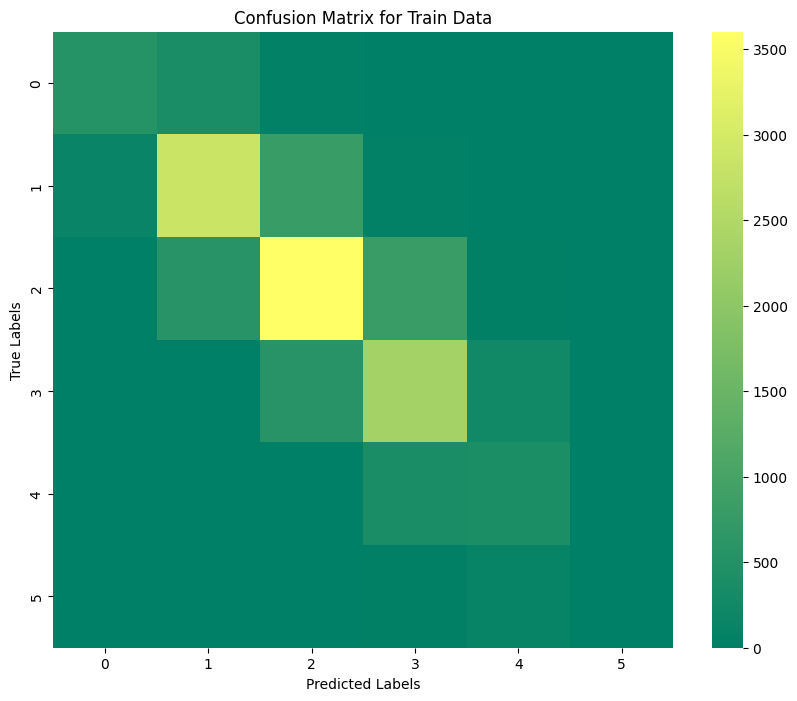

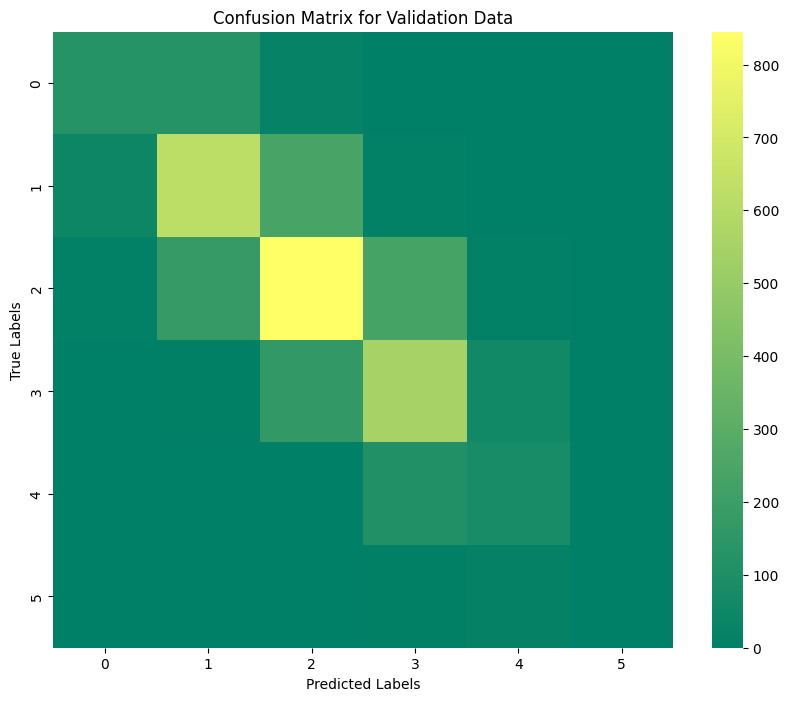

In [10]:
import matplotlib.pyplot as plt

y_train_pred = trainer.predict(ds_train).predictions.argmax(-1) # array
y_val_pred = trainer.predict(ds_val).predictions.argmax(-1)

y_train = ds_train['labels'] # list
y_val = ds_val['labels']

def print_cm(true_data,pred_data,title):
    plt.figure(figsize = (10,8))
    sns.heatmap(confusion_matrix(true_data,pred_data),cmap = 'summer')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for '+title)
    plt.show()


print_cm(y_train,y_train_pred,'Train Data')
print_cm(y_val,y_val_pred,'Validation Data')

#### Visualize the training procedure

got "no log" value in training loss, so I record the results manually

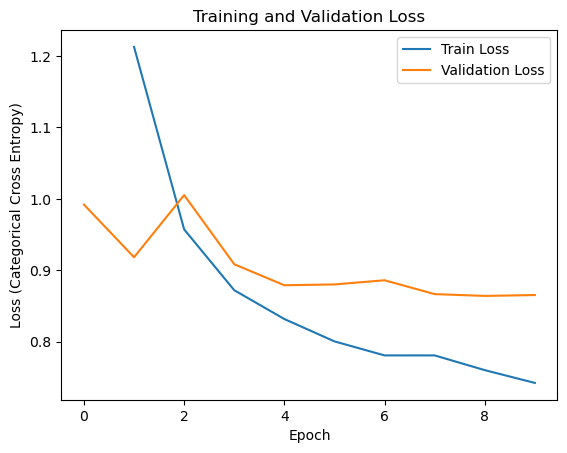

In [3]:
import matplotlib.pyplot as plt


train_loss = [float('-inf'),1.212500,0.957200,0.872100,0.831800,0.800500,0.780900,0.780900,0.760300,0.742400]
val_loss = [0.991912,0.918230,1.005216,0.908457,0.879039,0.880198,0.886024,0.866643,0.864128,0.865375]


epochs = [int(i) for i in range(10)]

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Categorical Cross Entropy)')
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.show()